# Desafio de Programação 6: Análise de sentimento

## Identificação:

**Nome do avatar: Genos**

**Matrícula: 190084731**

## Introdução

Neste exercício, nós utilizaremos Redes Neurais Recorrentes para implementar um algoritmo que detecte se um texto faz uma avaliação positiva ou negativa sobre um certo objeto, implementando uma rede neural em Pytorch.

Todas as informações necessárias para resolver esta tarefa estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Primeiramente, nós configuraremos o ambiente, permitindo o acesso ao seu Google Drive, de onde serão importados os datasets e as imagens do notebook, além de outros módulos adicionais.


A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.


In [46]:
#allows the drive to be accessed 
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# Pytorch
import torch

# modules to adequate the NN
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

# modules to process strings
from string import punctuation

# module to organize the words
from collections import Counter

# Measuring execution time
import time


Recomendamos que, antes de iniciar o treinamento da rede, você habilite uma GPU para executar o programa. Isso porque a arquitetura da rede neural usada aqui é bastante complexa e, por isso, apresenta um custo computacional bem maior quando comparada aos exemplos anteriores.

Sabemos que nem todos possuem GPU na máquina, mas, para nossa sorte, o Google Colaboratory permite a utilização de unidades de processamento (GPU ou TPU) de forma gratuita.

Para habilitar essa função, basta acessar na parte superior da página do Colab: **Ambiente de execução > Alterar o tipo de ambiente de execução > Acelerador de hardware**, selecionar a opção “**GPU**” e salvar.

Pronto, agora a célula responsável por procurar uma unidade de processamento verificará que a GPU está habilitada e fará uso desse _hardware accelerator_ para processar o código, obtendo uma solução bem mais rápida.

In [48]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
	if train_on_gpu: #Se sim
		device = torch.device('cuda') #Seleciona o device como GPU
		print("Treinando na GPU") #E manda a mensagem
	else: #Se não
		device = torch.device('cpu') #Seleciona o device como cpu
		print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
	return device

device = testar_gpu()

Treinando na GPU


## 1 Análise de Sentimento

Neste desafio de programação, desenvolveremos um algoritmo capaz de identificar se uma crítica a um produto é positiva ou negativa. Para isso, utilizaremos um dataset que contém comentários escritos por espectadores avaliando diferentes filmes. Cada avaliação está rotulada em duas classes, "positivo" e "negativo", como exemplificado na figura abaixo.

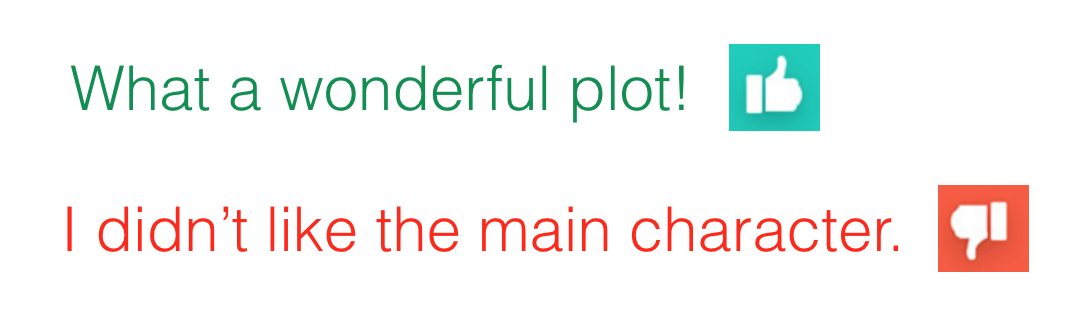


### 1.1 Arquitetura da rede

A arquitetura da rede consiste em uma camada de *embedding*, em que as palavras serão codificadas em vetores, uma camada recorrente, que receberá esse vetor como entrada, passando-os à LSTM (do inglês,*Long Short-Term Memory*) **COLOCAR ESPAÇO APÓS A VIRGULA** e, por fim, uma camada sigmoid, responsável por classificar a saída da LSTM em uma das duas classes possíveis. A imagem abaixo ilustra toda a estrutura proposta.

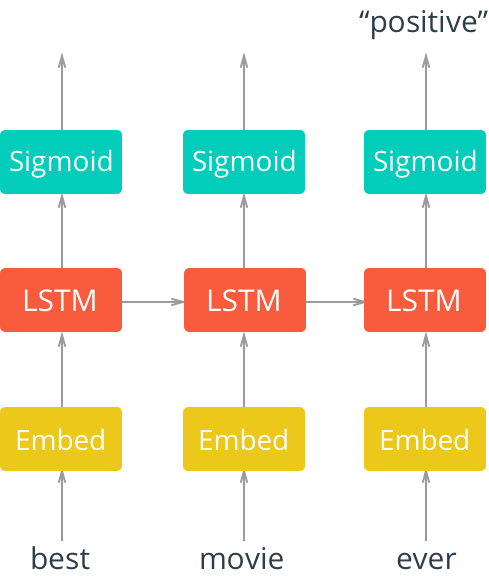


Aqui, é importante ressaltar alguns pontos:

* **Primeiro, passaremos as palavras em uma camada de *embedding*.** Esta camada é importante porque temos dezenas de milhares de palavras, de forma que precisaríamos de vetores muito grandes para representá-las utilizando *one-hot vectors*, tornando a representação ineficiente. Nesse caso, o objetivo da camada de *embedding* é a redução de dimensionalidade, e não a representação semântica. É possível utilizar um dicionário que traga essa representação semântica para os vetores, mas a ideia é que a rede entenda por conta própria quais palavras possuem viés positivo e quais possuem viés negativo.

* **Depois de codificadas, as palavras serão passadas para as células da LSTM.** 
As células da LSTM possuem conexões recorrentes em sua estrutura que nos permitem utilizar uma sequência de palavras como entrada, formando as sentenças que compõem as avaliações do dataset.

* **Após a LSTM, é importante adicionar uma camada de dropout para otimização da rede.** 

* **Por fim, a saída da LSTM é ligada a uma camada sigmoid.** Estamos utilizando a função sigmoid para fazer a classificação por se tratar de um problema com apenas 2 classes, que serão representadas por 0 e 1.

*Obs:* como mostrado na figura, a única saída que nos importa é a última, ou seja, a saída da célula da LSTM que classificará a última palavra da avaliação. Isso se deve ao fato de a LSTM possuir memória e enviar o que foi guardado às células subsequentes, de forma que a última célula faz a classificação levando em consideração todas as palavras da sentença, enquanto as células intermediárias possuem informações sobre o ínicio da sentença, mas não conhecem as palavras que virão a seguir.

### 1.2 Importação e visualização dos dados

Na célula abaixo, faremos a importação dos dados que serão utilizados para treinamento e teste da rede neural.

In [49]:
# read data from text files
with open('/content/drive/MyDrive/3° Semestre/IMLDL/Semana 7/Desafio de programacao 6/data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('/content/drive/MyDrive/3° Semestre/IMLDL/Semana 7/Desafio de programacao 6/data/labels.txt', 'r') as f:
    labels = f.read()

Assim, podemos fazer uma breve visualização dos dados importados

In [50]:
print(reviews[:1000])
print()
print(labels[:20])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

## 2 Processamento dos dados

### 2.1 Pré processamento

O primeiro passo para a construção do classificador é organizar os dados de maneira apropriada. Como vimos, utilizaremos uma camada de *embedding* para codificar cada palavra, mas, antes disso, precisamos fazer um pré processamento do nosso dataset.

Esse processo visa simplificar o dataset, retirando caracteres que não ajudarão na classificação, a fim de facilitar o processo de aprendizagem das redes neurais. O pré processamento será dividido em 3 partes:

1. Transformação de letras maiúsculas em minúsculas e exclusão da pontuação;
2. Retirada dos caracteres `\n`, que delimitam o início de uma nova linha;
3. Identificação de todas as palavras que compõem o dataset, para que sejam codificadas posteriormente.

Começaremos pelo primeiro passo, transformando as letras maiúsculas em minúsculas e removendo a pontuação presente nos textos do dataset. 

In [51]:
# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

Feito isso, podemos partir para a exclusão dos caracteres `\n`. Repare que esses caracteres se encontram entre o fim de uma avaliação e o começo de outra, de forma que podemos dividir o dataset a partir deles. Para isso, utilizaremos o método `split()`, que divide uma string a cada vez que aparece um caractere específico, no nosso caso, o caractere `\n`. Assim, o resultado desse método será a lista `reviews_split` preenchida por variáveis do tipo `string`, em que cada elemento abarcará o texto de uma avaliação do dataset.

In [52]:
# split by new lines and spaces
reviews_split = all_text.split('\n')

print('O número de reviews presentes no dataset é:', str(len(reviews_split)) + '.')

O número de reviews presentes no dataset é: 25001.


A partir da célula acima, percebemos que o dataset é composto por aproximadamente 25 mil avaliações.

Por fim, queremos saber a quantidade de palavras presentes em nosso dataset. Para isso, faremos a união de todas avaliações em uma única variável `all_text` que pode ser dividida a cada espaço em branco, de modo que cada divisão será uma palavra do dataset. 

In [53]:
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

print('O número de palavras presentes no dataset é:', str(len(words)) + '.')

O número de palavras presentes no dataset é: 6020196.


### 2.2 Codificação das palavras

Para que passemos as palavras pela camada de *embedding*, necessitamos codificá-las de alguma forma, já que o algoritmo não entenderia se passássemos variáveis do tipo `string` diretamente. A forma mais fácil de se fazer isso é criar um dicionário que mapeia as palavras do vocabulário em números inteiros, de modo que consigamos passá-los como entrada da nossa rede.

Agora, faremos essa codificação inicial, construindo um dicionário que fará o mapeamento das palavras. Repare que a numeração começa em 1 e não em 0. O motivo disso é que, futuramente, nós preencheremos alguns elementos com zeros, para que todos os vetores tenham o mesmo tamanho.

In [54]:
## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

Agora, codificaremos o texto das avaliações em números inteiros que serão guardados na variável `reviews_ints`.

In [55]:
## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

### 2.3 Codificação das labels

As labels são apresentadas no nosso dataset como: *negative* ou *positive*. Assim como fizemos para os textos utilizados como entrada da rede, precisamos codificar essas duas classes, convertendo-as para vetores preenchidos com valor 0 ou 1.

In [56]:
# 1=positive, 0=negative label conversion
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

### 2.4 Remoção de *Outliers*

Um passo adicional de pré processamento dos dados é a remoção de *outliers*, isto é, a retirada dos exemplos do dataset que sejam muito diferentes dos demais. Fazemos isso porque existe uma grande probabilidade de que as grandes diferenças desses exemplos sejam resultado da ocorrência de erros no processo de elaboração do dataset.

No caso apresentado, um tipo de *outlier* são os exemplos cujo tamanho do texto seja muito curto ou muito extenso. Nesse sentido, analisaremos qual é a quantidade de palavras utilizadas na crítica com menor e maior extensão.

In [57]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


A partir da célula acima, sabemos que a avaliação mais curta não contém nenhuma palavra, se tratando, obviamente, de um *outlier*. Entretanto, apenas com o resultado anterior, não é possível sabermos se é uma ocorrência isolada ou se existe mais de um exemplo com essa característica. Assim, procuraremos e excluiremos todos os exemplos que não contenham nenhuma palavra sequer.


In [58]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.

# get indices of any reviews with length 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


Excluídos os exemplos vazios, podemos seguir em frente no processamento dos dados. Os exemplos de maior extensão não serão tratados por agora, porque mais a frente nós uniformizaremos o tamanho das sentenças, truncando os exemplos que contenham muitas palavras.

### 2.5 Formação das sequências

Após a limpeza dos dados, podemos formar as sequências de palavras que de fato vão ser transformadas em vetores de entrada da rede neural. 

É importante lembrar que a LSTM receberá cada uma das palavras da sentença como entrada de uma célula recorrente. Com isso, a rede precisaria ter `N` células para receber como entrada uma frase com `N` palavras. Dessa forma, para utilizar sentenças muito longas, a LSTM precisaria ter um grande número de células, o que poderia torná-la muito complexa, além de elevar o seu custo computacional.

Para solucionar esse problema, devemos uniformizar um tamanho padrão (`seq_length`) para todas as sentenças do dataset, para todas as avaliações, de forma que todos os textos tenham o mesmo número de palavras. Assim, para avaliações que contenham um número de palavras menor do que `seq_length`, preencheremos os espaços faltantes com elementos `0`, enquanto, para textos com um número de palavras maior do que `seq_length`, nós truncaremos a sentença no elemento de índice igual a `seq_length`.

Agora, você deve preencher a função `pad_features()`, que executará o que foi descrito, ou seja, uma função que receberá um valor de `seq_length` e a lista com os textos mapeados em números inteiros e retornará uma matriz 2-D em que o número de linhas será o número de avaliações do dataset e o número de colunas será as palavras do exemplo respeitando o valor de `seq_length` escolhido. A correta implementação desta função lhe agregará **20 pontos** dentro da pontuação total deste desafio de programação.

In [59]:
def pad_features(reviews_ints, seq_length):
    """
    Retorna os features de 'review_ints', em que cada review é preenchida com 
    zeros ou truncada no tamanho determinado pela entrada 'seq_length'.

    Parâmetros
    ----------
    reviews_ints: list
      Lista que contém todas as avaliações (mapeadas em números inteiros), uma 
      em cada elemento da lista.

    seq_length: int
      Valor que será usado como tamanho padrão de cada linha da matriz 
      'features'.

    Retorna
    --------
    features: np.array
      Matriz que contém na linha 'i' o vetor de features do exemplo 'i'. O 
      número de colunas é igual a 'seq_length'.
    
    Instruções
    ------------
    Para cada vetor contido em 'reviews_ints', adicione zeros caso o tamanho
    do vetor seja menor que 'seq_length' ou trunque o vetor em 'seq_length' 
    caso o tamanho do vetor seja maior.
    """
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    #======================== YOUR CODE HERE =========================
    for ii, review in enumerate(reviews_ints):
      if len(review) != 0:
          features[ii, -len(review):] = np.array(review)[:seq_length]    
    #=================================================================
	   
    return features

Assim, utilizaremos essa função para gerar a variável `features`, que guardará todos os exemplos do dataset com tamanho uniforme. Para que consigamos visualizar como estão os nossos dados, printaremos as primeiras 10 palavras das primeiras 30 avaliações do dataset, utilizando `seq_length = 200`.

In [60]:
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

## 3. Divisão do Dataset

Com os dados pré-formatados, podemos dividi-los em datasets de treino e teste. Essa divisão será feita na proporção de 85% para o treinamento e 15% para o teste, como executado abaixo.

In [61]:
split_frac = 0.85

## split data into training and test data (features and labels, x and y)
split_idx = int(len(features)*split_frac)
train_x, test_x = features[:split_idx], features[split_idx:]
train_y, test_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(21250, 200) 
Test set: 		(3750, 200)


### 3.1 DataLoaders e Batching

Após a divisão dos dados, podemos organizá-los em DataLoaders, que serão utilizados para treinamento e teste da rede.

In [62]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

Assim, podemos visualizar o tamanho dos vetores criados após a divisão em batches.

In [63]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print()
print('Sample label size: ', sample_y.size()) # batch_size

Sample input size:  torch.Size([50, 200])

Sample label size:  torch.Size([50])


## 4. Construção do modelo

Com o dataset organizado, podemos estruturar o nosso modelo preditor. A estrutura da rede neural utilizada pode ser dividida em 4 partes:
1. Uma [camada de embedding](https://pytorch.org/docs/stable/nn.html#embedding) responsável por converter os números inteiros, que codificam as palavras, em vetores de tamanho específico.
2. Uma [camada LSTM](https://pytorch.org/docs/stable/nn.html#lstm) para entender a sequência de palavras e transformá-la em um vetor de tamanho pré-definido.
3. Uma camada de *dropout* com probabilidade 0.3.
4. Uma camada de saída fully-connected que transforma o vetor de saída da LSTM em um valor que seja 0 ou 1 aplicando a função sigmoid, a depender do viés do comentário feito.

### 4.1 Estruturação da rede

Agora, cabe a você preencher o método `__init__()` da classe `SentimentRNN`, configurando a [camada de *embedding*](https://pytorch.org/docs/stable/nn.html#embedding), a [LSTM](https://pytorch.org/docs/stable/nn.html#lstm), a camada de dropout e, por fim, a camada [fully_connected] com sigmoid a partir dos parâmetros de entrada:

*   Número de palavras do dataset: `vocab_size`;
*   Tamanho do vetor de saída: `output_size`;
*   Dimensão da camada de *embedding*: `embedding_dim`;
*   Dimensão da camada oculta: `hidden_dim`;
*   Número de camadas: `n_layers`;
*   Probabilidade de *dropout* entre camadas: `drop_prob`.

Além das entradas acima, a [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) **deve ser configurada com a entrada `batch_first = True`**. Esse parâmetro serve para que a rede entenda que a primeira dimensão dos dados de entrada será o `batch_size`.

O método `forward` já está preenchido e não precisa ser modificado, mas é fortemente recomendado que o aluno entenda o que cada linha de código está executando.

Por fim, o método `init_hidden`, que serve para inicializar a camada oculta da LSTM, responsável pela memória da rede, também já está preenchido e não precisa ser modificado.

A correta implementação do método `__init__()` lhe agregará **10 pontos** dentro da pontuação total deste desafio de programação.

In [64]:
class SentimentRNN(nn.Module):
    """
    Classe referente ao modelo que será usado para realizar a análise de 
    sentimento.
    
    Instruções
    ------------
    Defina as camadas da rede conforme a arquitetura pedida (camada de 
    embedding, camada LSTM, camada dropout com probabilidade 0.3 e camada fully 
    connected com sigmoid no fim). 
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):

        # Initialize the model by setting up the layers.

        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # ============================== YOUR CODE HERE ================================
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        # ==============================================================================

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)        
        lstm_out = lstm_out[:, -1, :] # getting the last time step output
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden

### 4.2 Instanciando a rede

Agora, devemos instanciar a rede neural para executar o seu treinamento e teste. Os parâmetros para essa instância já foram definidos, mas é recomendável que o aluno faça modificações nos valores de cada um deles, para entender a influência de cada um no resultado final.

In [65]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### 4.3 Treinamento do modelo

Agora, devemos definir os parâmetros de treinamento da nossa rede neural, como a função de perda, o otimizador, o *learning rate* e um parâmetro que ainda não utilizamos, o *clip*.

O *clip* serve para que evitemos gradientes com valores muito altos, que podem provocar o fenômeno conhecido como **explosão de gradientes**. Assim, esse parâmetro define um valor máximo para a norma do gradiente, funcionando como um limitante superior e inferior dessa variável.

Nós utilizaremos a Entropia Cruzada Binária ([BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss)) como função de perda e o [*AdamW*](https://pytorch.org/docs/master/generated/torch.optim.Adam.html) como otimizador com *learning rate* de 0,001.

In [66]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
clip = 5

Agora, você deve escrever o *loop* responsável por treinar e testar esta rede neural. O código deve executar um laço com valor de repetição igual a `epochs`, passando por todo o dataset de treino e teste **em cada uma dessas épocas**.

Esperamos como saída, os valores de custo de treinamento (`train_loss`), custo de teste (`test_loss`) e acurácia (`acc`) medida apenas com o dataset de teste.

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste Desafio de programação.

*Dica:* Para limitar os gradientes, utilize a função [`nn.utils.clip_grad_norm_()`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

In [67]:
"""
Treine os parâmetros das camadas de embedding e LSTM da rede contida em 
'model' com os exemplos contidos em 'data_train' (organizados por 
'train_loader'). Em seguida, teste a acurácia e o erro de classificação da 
rede com os exemplos contidos em 'data_test' (organizados por 
'loader_test').

Instruções
-------------
Efetue o treinamento e testa da rede, realizando uma passagem dos datasets 
de treino e de teste a cada época, calculando o erro de classificação de 
cada 'batch' e atualizando os parâmetros da rede com o otimizador definido 
anteriormente, e então calcule o erro médio de classificação pela rede dos
exemplos de treino (guardando o resultado em 'train_loss'), o error médio
de classificação pela rede dos exemplos de teste (guardando o resultado em
'test_loss') e a acurácia de classificação pela rede dos exemplos de teste
(guardando o resultado em 'acc').
Nota
-------------
O aluno pode fazer uso de quaisquer ferramentas fornecidas pelo Pytorch
para implementar esta função.

É importante lembrar de utilizar a GPU para efetuar quaisquer processamentos 
possíveis (utilize a função 'to(device)') a fim de otimizar o tempo de 
execução.
"""

START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0

epochs = 5
model.train().to(device)
for epoch in range(1, epochs+1):
  start = time.time()
  
  train_loss, test_loss, acc = 0,0,0
    
  # ============================== YOUR CODE HERE ================================
  h = model.init_hidden(batch_size)
  
  for inputs, labels in train_loader:
    time1epoch += 1 

    inputs, labels = inputs.to(device), labels.to(device)
    
    h = tuple([each.data for each in h])

    model.zero_grad()

    output, h = model(inputs, h)

    test_loss = criterion(output.squeeze(), labels.float())
    test_loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(),clip).to(device)
    optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval().to(device)
    num_correct = 0
    model.train().to(device)

  for inp, lbl in test_loader:
    val_h = tuple([each.data for each in val_h])
    inp, lbl = inp.to(device), lbl.to(device)
    out, val_h = model(inp, val_h)
    val_loss = criterion(out.squeeze(), lbl.float())
    val_losses.append(val_loss.item())
    pred = torch.round(out.squeeze())
    correct_tensor = pred.eq(lbl.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    acc = num_correct/len(test_loader.dataset)
    
    

    time1epoch = -time1epoch
  # ==============================================================================
  
  end = time.time()

  list_train_loss.append(train_loss), list_test_loss.append(test_loss), list_acc.append(acc)

  Time = end - start
  if epoch == 1:
    time1epoch = Time

  print('Epoch: ', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
  
END = time.time()

print()
TIME = (END - START) - time1epoch
print('\n Time spent during training, excluding first epoch: {:.2f}'.format(TIME), 'seconds.')

Epoch:  1  loss: 0.6001  Accuracy: 0.73  Time spent this epoch: 23.87 seconds.
Epoch:  2  loss: 0.3915  Accuracy: 0.79  Time spent this epoch: 23.77 seconds.
Epoch:  3  loss: 0.2612  Accuracy: 0.81  Time spent this epoch: 23.84 seconds.
Epoch:  4  loss: 0.1497  Accuracy: 0.80  Time spent this epoch: 24.26 seconds.
Epoch:  5  loss: 0.1712  Accuracy: 0.79  Time spent this epoch: 23.83 seconds.


 Time spent during training, excluding first epoch: 95.71 seconds.


### 4.4 Utilização do modelo

Com o modelo treinado e testado com exemplos do dataset, queremos visualizar o funcionamento da nossa rede ao receber avaliações feitas por nós mesmos. Entretanto, como vimos, é necessário pré processar qualquer sentença que será usada como entrada da rede, assim como fizemos com o nosso dataset de treino e teste.

Para isso, preencha a função `pre_processing()`, que receberá como entrada uma variável do tipo `string` contendo uma frase qualquer e retornará um vetor pronto para ser utilizado como entrada no nosso modelo treinado.

A correta implementação desta função lhe agregará **20 pontos** dentro da pontuação total deste Desafio de programação.


In [68]:
def pre_processing(test_review):

    """
    Pré-processa a string de entrada 'test_review' de forma a adequá-la como
    parâmetro de entrada para a rede.

    Parâmetros
    ----------
    test_review: str
      String referente ao comentário que se deseja analisar o sentimento pela 
      rede neural.

    Retorna
    --------
    features: torch.tensor
      Tensor que contém na linha o vetor de features do exemplo em questão. O 
      tamanho do tensor é igual a 'seq_length'.
    
    Instruções
    ------------
    Realize as mesmas operações que foram feitas com o dataset de treino: i) 
    colocar todo o texto em letras minúsculas; ii) excluir pontuação; iii) 
    troque as palavras por índices do dicionário 'vocab_to_int'; iv) trunque 
    ou adicione zeros ao vetor para que seu tamanho seja igual a 'seq_length' 
    (pode ser feito chamando a função pad_features); e v) passe o tensor para a
    GPU ('x.to(device)').
    """
    
  # ============================== YOUR CODE HERE ================================
    from string import punctuation
    test_review = test_review.lower()
    
    test_text = ''.join([c for c in test_review if c not in punctuation])
    
    test_words = test_text.split()
    
    feature_tensor = []
    feature_tensor.append([vocab_to_int.get(word,0) for word in test_words])
    feature_tensor = pad_features(feature_tensor,seq_length)
    feature_tensor = torch.Tensor(feature_tensor)
  # ==============================================================================

    return feature_tensor

# test code and generate tokenized review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
feature_tensor = pre_processing(test_review_neg)
print(feature_tensor.size())

torch.Size([1, 200])


Por fim, iremos implementar a função de predição de um comentário qualquer. Para isso, preencha a função `predict()`, que receberá uma sentença em formato `string` , converte-la-á em um vetor utilizando a função `pre_processing` e utilizará esse vetor como entrada da rede neural, que será responsável por classificar o viés da avaliação feita.

Entretanto, é importante nos atentarmos ao fato de que existe a possibilidade da rede receber sentenças que não pertencem ao contexto para o qual a rede foi treinada, como, por exemplo, avaliações de filmes feitas em outros idiomas ou ainda frases que não se tratam de avaliações de filmes, de forma que a rede não seria capaz de fazer uma classificação coerente desse tipo de dado.

Uma maneira de avaliar a relevância de uma classificação é analisar a saída da sigmoid. Quanto mais próxima de 0 ou de 1, maior é a confiabilidade da classificação feita, ao passo que saídas de valores intermediários trazem classificações de menor credibilidade.

Assim, para evitar que a nossa função de predição apresente pouca confiabilidade, adicionaremos um limiar de decisão que definirá o intervalo em que a saída da rede pode ser considerada relevante. Sabendo que a saída da nossa rede é uma sigmoid e que essa função retorna um valor entre 0 e 1, vamos definir os limiares da seguinte forma:

*   **Negativo:** saída da rede entre 0 e 0.25;
*   **Inconclusivo:** saída da rede entre 0.25 e 0.75;
*   **Positivo:** saída da rede entre 0.75 e 1;

Preencha a função abaixo respeitando esse limiares, retornando as strings `'Negativo'` para o primeiro caso, `'Resultado inconclusivo'` para o segundo e `'Positivo'` para o terceiro.

A correta implementação desta função lhe agregará **20 pontos** dentro da pontuação total deste Desafio de programação.


In [69]:
def predict(test_review):
    
    model.eval()

    """
    Recebe uma string que será pré-processada e então analisada pela rede 
    neural. Com base no valor de saída da rede, define um limiar de 
    confiabilidade da predição, classificando o comentário como "Positivo",
    "Negativo" ou "Inconclusivo".

    Parâmetros
    ----------
    test_review: str
      String referente ao comentário que se deseja analisar o sentimento pela 
      rede neural.
    
    Instruções
    ------------
    Pré-processe a string 'test_review', chamando a função 'pre_processing()', e
    então passe o vetor pré-processado como entrada à rede neural. Analise o 
    valor de saída da rede e printe na tela "Positivo", "Negativo" ou 
    "Inconclusivo" com base nos limiares definidos.
    """

    # ============================== YOUR CODE HERE ================================
    
    model.eval()
    
    test_ints = pre_processing(test_review)
    
    sequence_lenght = seq_length
    features = pad_features(test_ints,sequence_lenght)
    
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)    
    
    h = model.init_hidden(batch_size)
    
    feature_tensor = feature_tensor.to(device)
    
    output, h = model(feature_tensor, h)
    
    pred = torch.round(output.squeeze())
    
    if output.item() >= 0.75:
        print('Positivo')
        
    elif output.item() < 0.75 and output.item() > 0.25:
        print('Inconclusivo')
        
    elif output.item() <= 0.25:
        print('Negativo')
   	# ==============================================================================
        

Por fim, testaremos a rede criada utilizando 4 frases, sendo elas: 

1.   Uma avaliação negativa;
2.   Uma avaliação positiva
3.   Uma sentença descorrelatada do contexto de treinamento;
4.   Uma avaliação em outro idioma que não aquele para qual a rede neural foi treinada

In [70]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
predict(test_review_neg)
print()

# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
predict(test_review_pos)
print()

# uncorrelated sentence
test_review_uncorrelated = 'Curso IMLDL - 1/2021.'
predict(test_review_uncorrelated)
print()

# review in another language
test_review_another_lenguage = 'O filme é incrível. O melhor filme que já assisti.'
predict(test_review_another_lenguage)
print()

Negativo

Positivo

Inconclusivo

Inconclusivo



Se você perceber que o teste acima não produziu os valores esperados, ajuste os limiares de decisão e treine a rede novamente, repetindo esse processo até que o resultado seja satisfatório.